In [1]:
import pandas as pd
import numpy as np

# Load and transform the data
data = pd.read_csv('../../data/sim1/vns_dataset_threshold_type.csv')

# data = pd.get_dummies(data, columns=['fibre_type'])

data.loc[data['fibre_type'] == 'AB', 'fibre_type'] = 0.0
data.loc[data['fibre_type'] == 'C', 'fibre_type'] = 1.0

data = data.astype('float32')
data.head()

data_ab = data.loc[data['fibre_type'] == 0.0, :]
data_c = data.loc[data['fibre_type'] == 1.0, :]

In [55]:
# 3D scatter plot of pulse width, amplitude and activation level
import plotly.graph_objs as go
import plotly.express as px

# data_c = data.loc[data['fibre_type'] == 1.0, :]
# data_ = data_c.loc[data_c['nerve_a'] == 194.339, :]

# Create the 3D scatter plot
# data_c["frequency"] = data_c["frequency"].astype(str)
fig = px.scatter_3d(
    data_frame=data_c,
    x='amplitude',
    y='pulse_width',
    z='activation_level',
    color='frequency',
    opacity=0.6,
    color_continuous_scale='viridis',
)

# alternative to viridis

# dict where fibre_type is 0.0, it should be 5 and where it is 1.0, it should be 10
fibre_type = data_c['fibre_type'].values
fibre_type_size = np.where(fibre_type == 0.0, 15, 10)

# Update the marker size
fig.update_traces(marker=dict(size=fibre_type_size))

# remove white outline
fig.update_traces(marker=dict(line=dict(width=0)))

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Amplitude (mA)',
        yaxis_title='Pulse Width (ms)',
        zaxis_title='Activation Level',
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Update legend text
fig.update_layout(
    coloraxis_colorbar=dict(title='Nerve Major\nDiameter (μm)'),
)
# add a title
# fig.update_layout(title_text='Unmyelinated fibre activation level')

# Show the plot
fig.show()

Correlation with the activation level:
activation_level    1.000000
charge              0.065118
amplitude           0.026441
pulse_width         0.020380
frequency           0.000724
nerve_b            -0.005957
nerve_a            -0.019354
fibre_type         -0.047532
Name: activation_level, dtype: float64


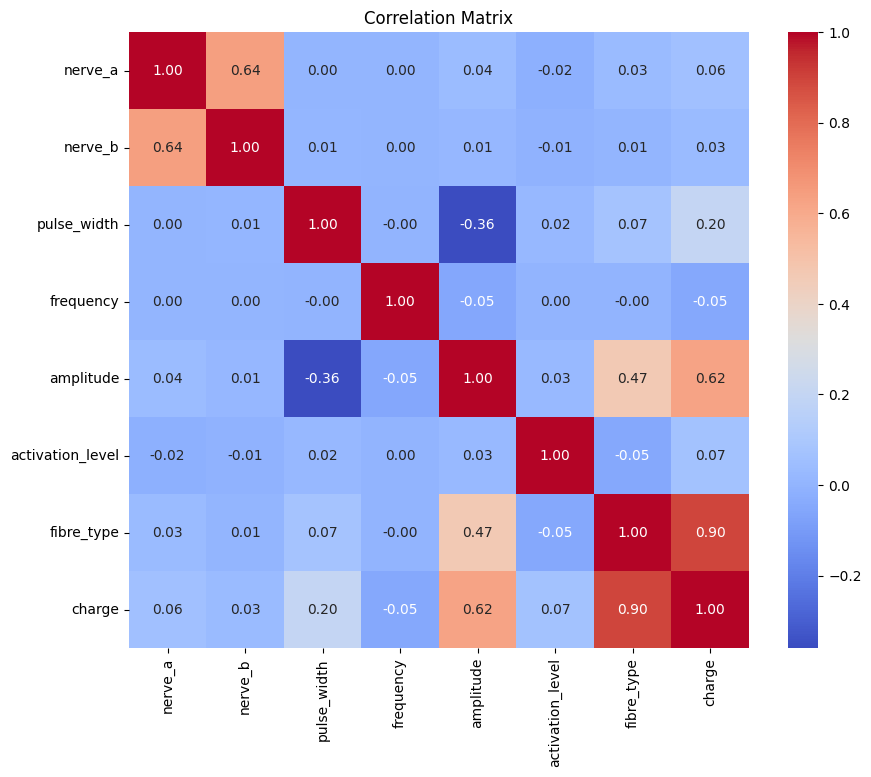

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the correlation matrix
correlation_matrix = data.corr()

# Extract correlations with the final column
final_column_correlation = correlation_matrix['activation_level'].sort_values(ascending=False)

# Print the correlations
print("Correlation with the activation level:")
print(final_column_correlation)

# Plot the correlations with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [13]:
data.head()

nerve_a     nerve_b  pulse_width  frequency  amplitude  \
0  136.812897  119.578697          0.2        1.0   0.080818   
1  136.812897  119.578697          0.2        1.0   0.083718   
2  136.812897  119.578697          0.2        1.0   0.086135   
3  136.812897  119.578697          0.2        1.0   0.089036   
4  136.812897  119.578697          0.2        1.0   0.092903   

   activation_level  fibre_type    charge  
0            0.0256         0.0  0.016164  
1            0.0513         0.0  0.016744  
2            0.0769         0.0  0.017227  
3            0.1026         0.0  0.017807  
4            0.1282         0.0  0.018581

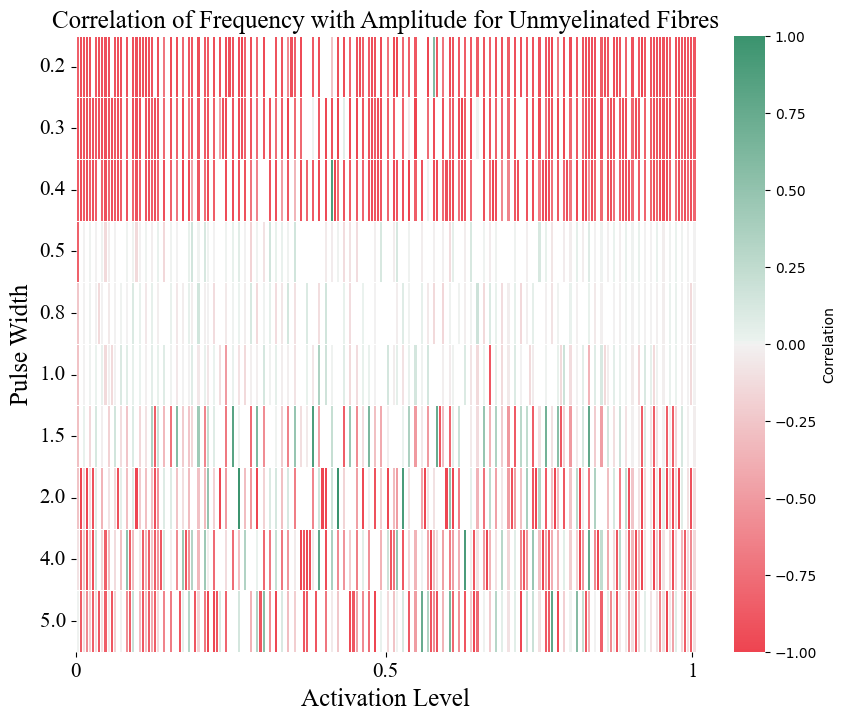

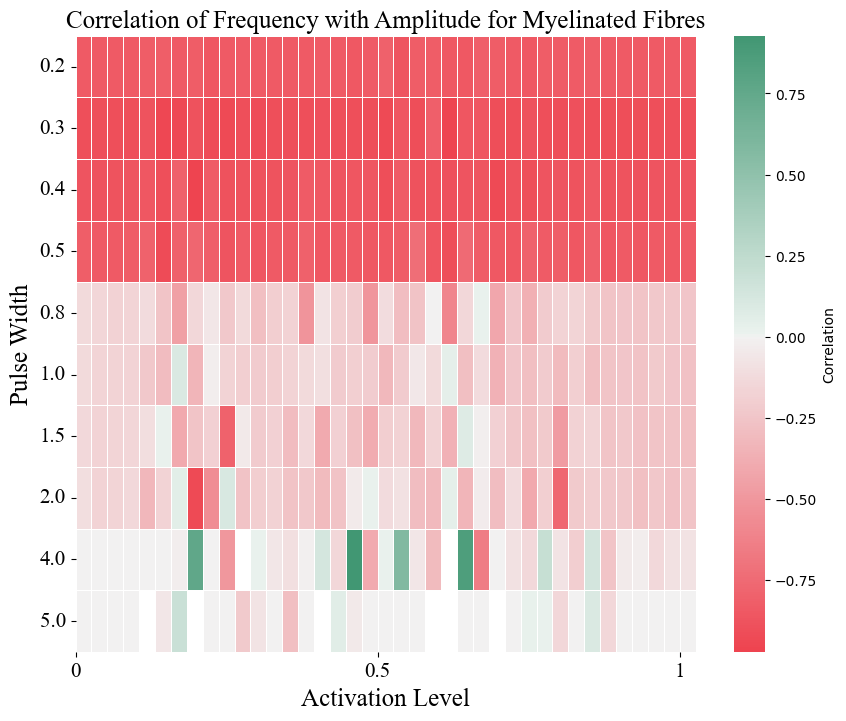

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Step 1: Separate the dataset into two subsets based on fibre_type
data_fibre_1 = data[data['fibre_type'] == 1]
data_fibre_0 = data[data['fibre_type'] == 0]

# Function to analyze the effect of frequency on amplitude for given pulse_width and activation_level
def analyze_effect(data_subset, pulse_width_val, activation_level_val):
    # Filter data for the specific pulse_width and activation_level
    subset_data = data_subset[(data_subset['pulse_width'] == pulse_width_val) & (data_subset['activation_level'] == activation_level_val)]
    
    if len(subset_data) > 2:  # Ensure enough data points exist for correlation calculation
        # Calculate the correlation between frequency and amplitude
        correlation = subset_data[['frequency', 'amplitude']].corr().iloc[0, 1]
        return correlation
    else:
        return None

# Step 2: Get unique pulse_width and activation_level combinations from the dataset
pulse_width_values = data['pulse_width'].unique()
activation_level_values = data['activation_level'].unique()

# Initialize lists to store results
sweep_results_fibre_1 = []
sweep_results_fibre_0 = []

# Step 3: Sweep through all combinations of pulse_width and activation_level
for pulse_width_val in pulse_width_values:
    for activation_level_val in activation_level_values:
        # Analyze for fibre_type = 1
        correlation_fibre_1 = analyze_effect(data_fibre_1, pulse_width_val, activation_level_val)
        if correlation_fibre_1 is not None:
            sweep_results_fibre_1.append({
                'Pulse Width': pulse_width_val,
                'Activation Level': activation_level_val,
                'Correlation': correlation_fibre_1,
                'Fibre Type': 1
            })
        
        # Analyze for fibre_type = 0
        correlation_fibre_0 = analyze_effect(data_fibre_0, pulse_width_val, activation_level_val)
        if correlation_fibre_0 is not None:
            sweep_results_fibre_0.append({
                'Pulse Width': pulse_width_val,
                'Activation Level': activation_level_val,
                'Correlation': correlation_fibre_0,
                'Fibre Type': 0
            })

# Step 4: Convert results to DataFrames
results_fibre_1_df = pd.DataFrame(sweep_results_fibre_1)
results_fibre_0_df = pd.DataFrame(sweep_results_fibre_0)

# Combine both results into a single DataFrame
sweep_results_df = pd.concat([results_fibre_1_df, results_fibre_0_df], ignore_index=True)

# Step 5: Visualize the results with a heatmap (no annotations, with colorbar for red-negative and green-positive)
def visualize_sweep_results(results_df, fibre_type):
    pivot_table = results_df.pivot(index='Pulse Width', columns='Activation Level', values='Correlation')
    plt.figure(figsize=(10, 8))
    
    # Define a custom colormap (red for negative, green for positive correlations)
    cmap = sns.diverging_palette(150, 10, s=80, l=55, as_cmap=True).reversed()  # Explicitly red-to-green palette

    # Generate heatmap without text annotations, with font set to Times and size 14
    sns.heatmap(pivot_table, cmap=cmap, center=0, linewidths=0.5, cbar_kws={'label': 'Correlation'})
    
    # Set font properties
    plt.title(f'Correlation of Frequency with Amplitude for {'Myelinated' if fibre_type == 0 else 'Unmyelinated'} Fibres', fontsize=18, fontname='Times New Roman')
    plt.xlabel('Activation Level', fontsize=18, fontname='Times New Roman')
    plt.ylabel('Pulse Width', fontsize=18, fontname='Times New Roman')
    
    # Set tick labels with Times New Roman font and size 14, only for 0, 0.5, and 1
    plt.xticks(ticks=[0, pivot_table.shape[1] // 2, pivot_table.shape[1] - 1], 
               labels=[0, 0.5, 1], fontsize=15, fontname='Times New Roman', rotation=0)
    plt.yticks(fontsize=15, fontname='Times New Roman', rotation=0)
    plt.savefig(f'heatmap-corr-{fibre_type}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'heatmap-corr-{fibre_type}.eps', dpi=300, format='eps', bbox_inches='tight')
    plt.show()

# Visualize for fibre_type = 1
visualize_sweep_results(results_fibre_1_df, 1)

# Visualize for fibre_type = 0
visualize_sweep_results(results_fibre_0_df, 0)


# Optionally save the results to a CSV file
# sweep_results_df.to_csv('sweep_results_frequency_amplitude.csv', index=False)


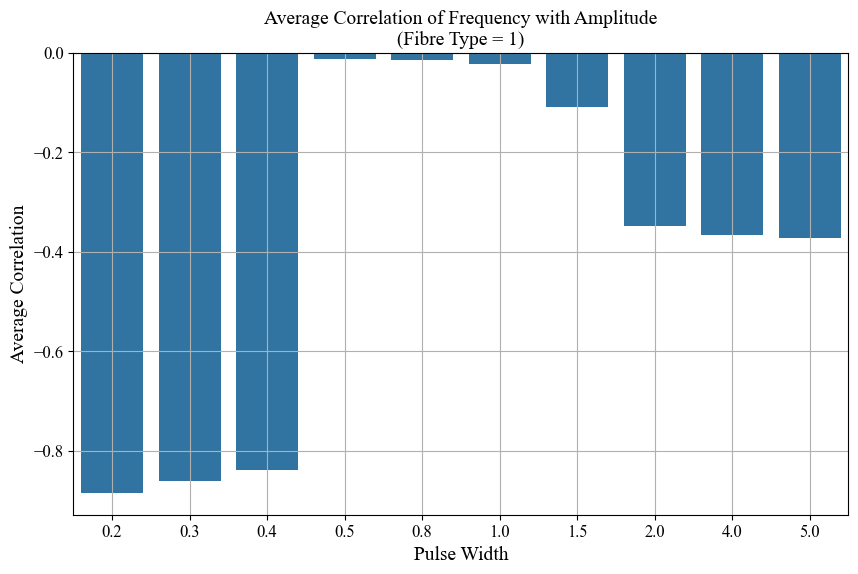

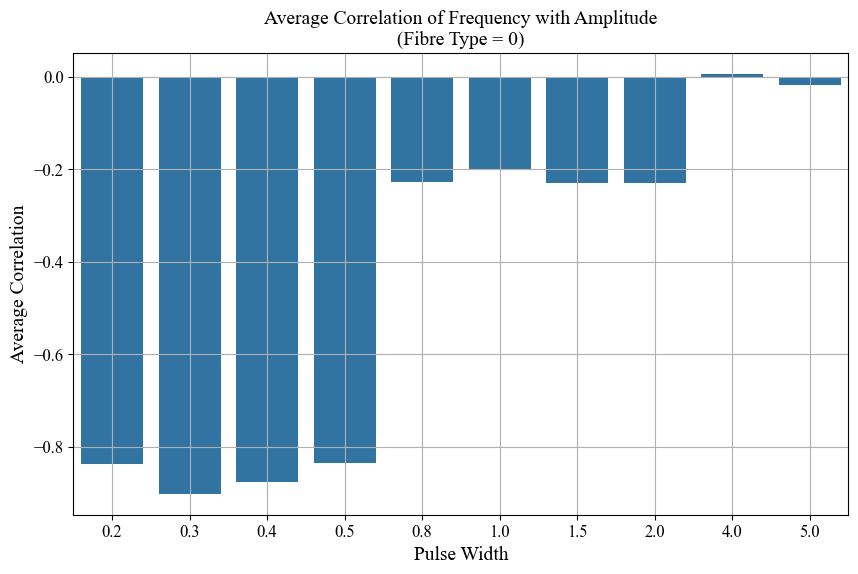

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Separate the dataset into two subsets based on fibre_type
data_fibre_1 = data[data['fibre_type'] == 1]
data_fibre_0 = data[data['fibre_type'] == 0]

# Function to analyze the effect of frequency on amplitude for given pulse_width and activation_level
def analyze_effect(data_subset, pulse_width_val, activation_level_val):
    # Filter data for the specific pulse_width and activation_level
    subset_data = data_subset[(data_subset['pulse_width'] == pulse_width_val) & (data_subset['activation_level'] == activation_level_val)]
    
    if len(subset_data) > 2:  # Ensure enough data points exist for correlation calculation
        # Calculate the correlation between frequency and amplitude
        correlation = subset_data[['frequency', 'amplitude']].corr().iloc[0, 1]
        return correlation
    else:
        return None

# Step 2: Get unique pulse_width and activation_level combinations from the dataset
pulse_width_values = data['pulse_width'].unique()
activation_level_values = data['activation_level'].unique()

# Initialize lists to store results
sweep_results_fibre_1 = []
sweep_results_fibre_0 = []

# Step 3: Sweep through all combinations of pulse_width and activation_level
for pulse_width_val in pulse_width_values:
    for activation_level_val in activation_level_values:
        # Analyze for fibre_type = 1
        correlation_fibre_1 = analyze_effect(data_fibre_1, pulse_width_val, activation_level_val)
        if correlation_fibre_1 is not None:
            sweep_results_fibre_1.append({
                'Pulse Width': pulse_width_val,
                'Activation Level': activation_level_val,
                'Correlation': correlation_fibre_1,
                'Fibre Type': 1
            })
        
        # Analyze for fibre_type = 0
        correlation_fibre_0 = analyze_effect(data_fibre_0, pulse_width_val, activation_level_val)
        if correlation_fibre_0 is not None:
            sweep_results_fibre_0.append({
                'Pulse Width': pulse_width_val,
                'Activation Level': activation_level_val,
                'Correlation': correlation_fibre_0,
                'Fibre Type': 0
            })

# Step 4: Convert results to DataFrames
results_fibre_1_df = pd.DataFrame(sweep_results_fibre_1)
results_fibre_0_df = pd.DataFrame(sweep_results_fibre_0)

# Step 5: Calculate average correlation for each pulse width
def calculate_average_correlation(results_df):
    # Group by Pulse Width and calculate the mean correlation
    avg_correlation = results_df.groupby('Pulse Width')['Correlation'].mean().reset_index()
    return avg_correlation

# Calculate average correlation for fibre_type = 1 and fibre_type = 0
avg_correlation_fibre_1 = calculate_average_correlation(results_fibre_1_df)
avg_correlation_fibre_0 = calculate_average_correlation(results_fibre_0_df)

# Step 6: Plot the average correlations in a bar chart
def plot_avg_correlation(avg_correlation_df, fibre_type):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Pulse Width', y='Correlation', data=avg_correlation_df)#, palette="RdYlGn")
    
    # Set font properties and labels
    plt.title(f'Average Correlation of Frequency with Amplitude\n(Fibre Type = {fibre_type})', fontsize=14, fontname='Times New Roman')
    plt.xlabel('Pulse Width', fontsize=14, fontname='Times New Roman')
    plt.ylabel('Average Correlation', fontsize=14, fontname='Times New Roman')
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')
    plt.grid(True)
    plt.show()

# Plot for fibre_type = 1
plot_avg_correlation(avg_correlation_fibre_1, 1)

# Plot for fibre_type = 0
plot_avg_correlation(avg_correlation_fibre_0, 0)

# Optionally save the average correlations to CSV
# avg_correlation_fibre_1.to_csv('avg_correlation_fibre_1.csv', index=False)
# avg_correlation_fibre_0.to_csv('avg_correlation_fibre_0.csv', index=False)


In [8]:
avg_correlation_fibre_0.head()

Pulse Width  Correlation
0          0.2    -0.836978
1          0.3    -0.902058
2          0.4    -0.875679
3          0.5    -0.834714
4          0.8    -0.227988

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


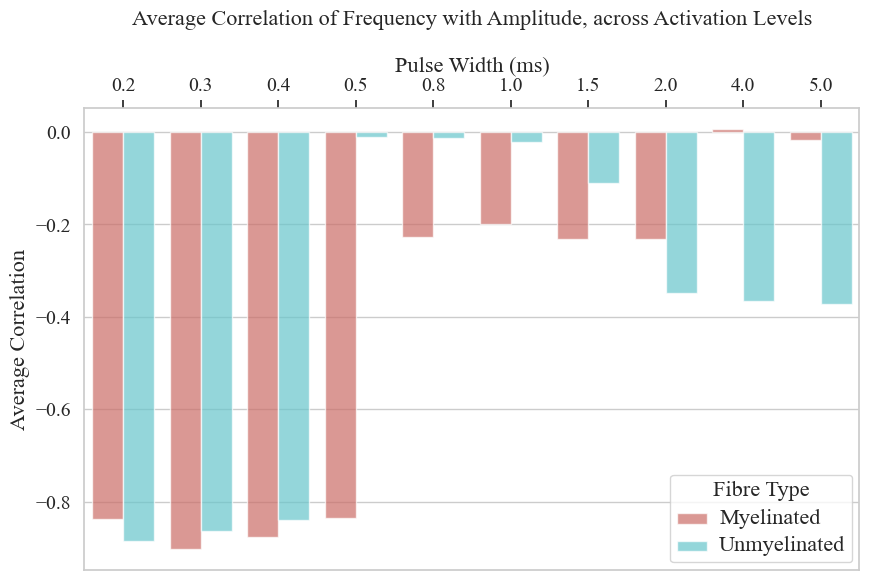

In [46]:
import matplotlib as mpl
mpl.rc('font', family='serif', serif='Times New Roman')

avg_correlation_fibre_0['Fibre Type'] = 'Myelinated'
avg_correlation_fibre_1['Fibre Type'] = 'Unmyelinated'

avg_correlations = pd.concat([avg_correlation_fibre_0, avg_correlation_fibre_1], ignore_index=True)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Times New Roman'})

sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

# Plot the average correlations in a bar chart
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title('Average Correlation of Frequency with Amplitude, across Activation Levels\n', fontsize=16, fontname='Times New Roman')
plt.grid(True)
g = sns.barplot(x='Pulse Width', y='Correlation', data=avg_correlations, hue='Fibre Type', palette='hls', alpha=0.7)
# g.despine(left=True)
plt.ylabel('Average Correlation', fontsize=16, fontname='Times New Roman')
# plt.legend(title='Fibre Type', fontsize='14', loc='lower right')
plt.setp(g.get_legend().get_texts(), fontname='Times New Roman', fontsize=16) 
plt.setp(g.get_legend().get_title(), fontname='Times New Roman', fontsize=16)  
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.xlabel('Pulse Width (ms)', fontsize=16, fontname='Times New Roman')
plt.setp(g.get_xticklabels(), fontname='Times New Roman', fontsize=14)  
plt.setp(g.get_yticklabels(), fontname='Times New Roman', fontsize=14)  
plt.savefig('avg_correlation_frequency.png', dpi=300, bbox_inches='tight')
plt.savefig('avg_correlation_frequency.eps', dpi=300, format='eps', bbox_inches='tight')
plt.show()

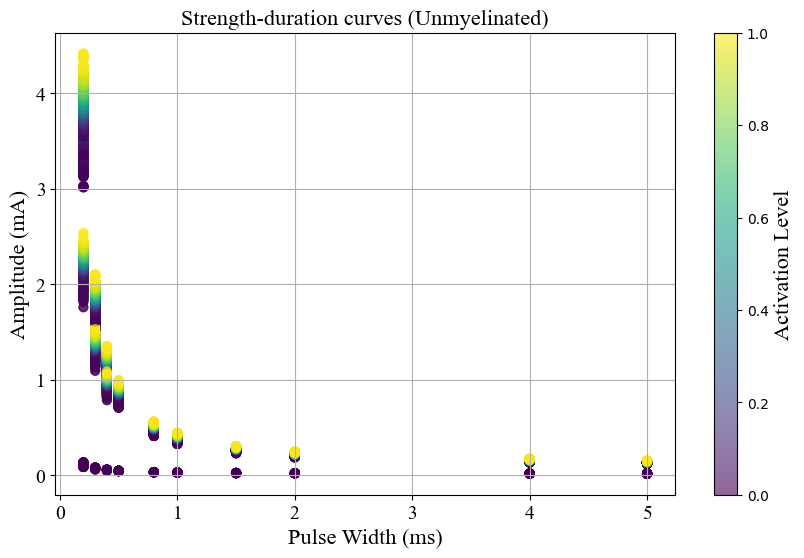

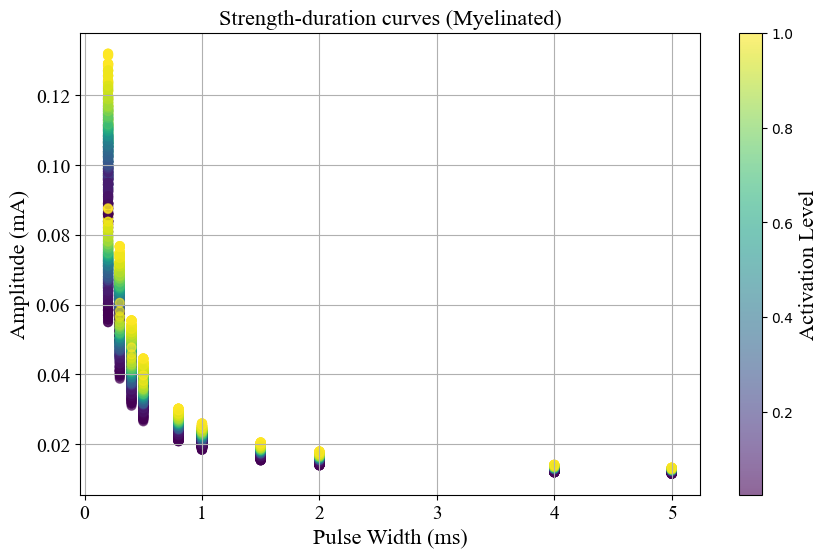

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Separate the dataset into two subsets based on fibre_type
data_fibre_1 = data[data['fibre_type'] == 1]
data_fibre_0 = data[data['fibre_type'] == 0]

# Step 2: Plot amplitude vs pulse width for all activation levels for fibre_type = 1
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_fibre_1['pulse_width'], data_fibre_1['amplitude'], 
                      c=data_fibre_1['activation_level'], cmap='viridis', s=40, alpha=0.6)
plt.colorbar(scatter).set_label(label='Activation Level', fontsize=16, fontname='Times New Roman')
plt.title(f'Strength-duration curves (Unmyelinated)', fontsize=16, fontname='Times New Roman')
plt.xlabel('Pulse Width (ms)', fontsize=16, fontname='Times New Roman')
plt.ylabel('Amplitude (mA)', fontsize=16, fontname='Times New Roman')
plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')
plt.grid(True)
plt.show()

# Step 3: Plot amplitude vs pulse width for all activation levels for fibre_type = 0
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_fibre_0['pulse_width'], data_fibre_0['amplitude'], 
                      c=data_fibre_0['activation_level'], cmap='viridis', s=40, alpha=0.6)
plt.colorbar(scatter).set_label(label='Activation Level', fontsize=16, fontname='Times New Roman')
plt.title(f'Strength-duration curves (Myelinated)', fontsize=16, fontname='Times New Roman')
plt.xlabel('Pulse Width (ms)', fontsize=16, fontname='Times New Roman')
plt.ylabel('Amplitude (mA)', fontsize=16, fontname='Times New Roman')
plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')
plt.grid(True)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


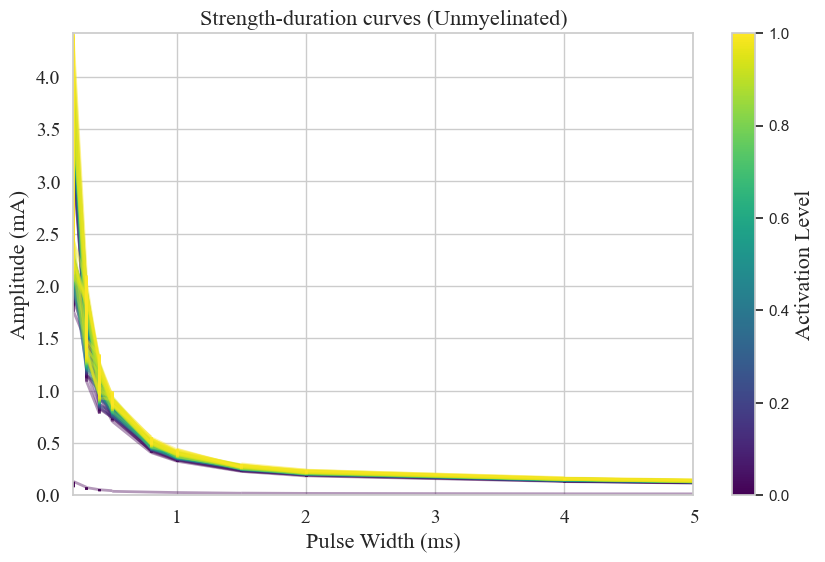

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


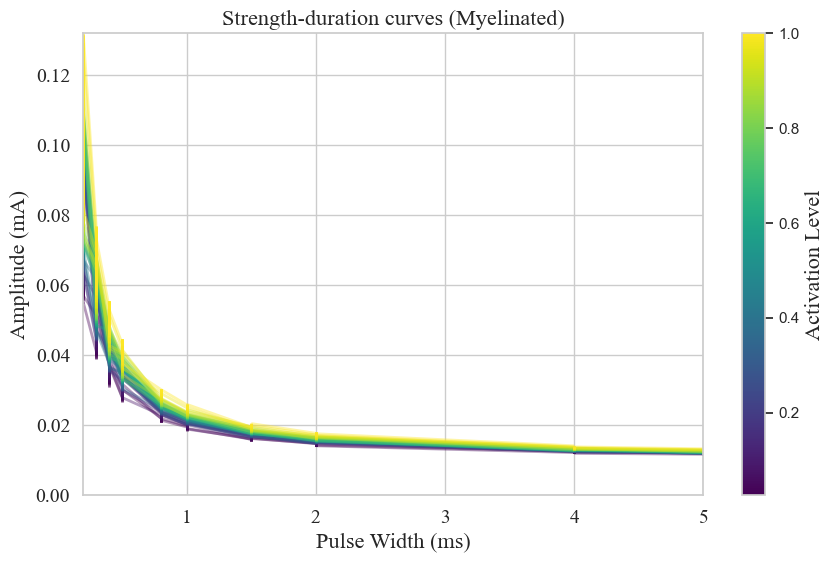

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

# Step 1: Separate the dataset into two subsets based on fibre_type
data_fibre_1 = data[data['fibre_type'] == 1]
data_fibre_0 = data[data['fibre_type'] == 0]

# Step 2: Function to filter out incomplete activation levels
def filter_incomplete_activation_levels(data_subset):
    # Find all pulse_width values
    all_pulse_widths = set(data_subset['pulse_width'].unique())
    
    # Find activation levels that have all pulse_width values
    valid_activation_levels = []
    for activation_level in data_subset['activation_level'].unique():
        pulse_widths_for_level = set(data_subset[data_subset['activation_level'] == activation_level]['pulse_width'])
        if pulse_widths_for_level == all_pulse_widths:  # Only keep activation levels with all pulse width values
            valid_activation_levels.append(activation_level)
    
    # Filter the dataset to only include valid activation levels
    filtered_data = data_subset[data_subset['activation_level'].isin(valid_activation_levels)]
    return filtered_data

# Step 3: Define a function to plot amplitude vs pulse width with a colorbar for activation levels
def plot_strength_duration(data_subset, fibre_type, title):
    # Filter data to remove incomplete activation levels
    data_subset_filtered = filter_incomplete_activation_levels(data_subset)

    plt.figure(figsize=(10, 6))

    # Get unique activation levels and normalize them for colormap
    activation_levels = data_subset_filtered['activation_level'].unique()
    norm = plt.Normalize(activation_levels.min(), activation_levels.max())
    cmap = plt.cm.viridis
    
    # Initialize a list to store line segments and their colors
    line_segments = []
    
    # Generate line segments for each activation level
    for activation_level in sorted(activation_levels):
        # Filter the data and sort by pulse_width to prevent "closing the shape"
        subset = data_subset_filtered[data_subset_filtered['activation_level'] == activation_level].sort_values(by='pulse_width')
        points = np.array([subset['pulse_width'], subset['amplitude']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        line_segments.append(LineCollection(segments, color=cmap(norm(activation_level)), alpha=0.4, linewidth=2))
    
    # Add the line segments to the plot
    for segment in line_segments:
        plt.gca().add_collection(segment)

    # Set limits for the axes
    plt.xlim(data_subset_filtered['pulse_width'].min(), data_subset_filtered['pulse_width'].max())
    plt.ylim(data_subset_filtered['amplitude'].min(), data_subset_filtered['amplitude'].max())
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required to work with colorbar
    ax = plt.gca()
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Activation Level', fontsize=16, fontname='Times New Roman')
    
    # Set labels and title
    plt.title(title, fontsize=16, fontname='Times New Roman')
    plt.xlabel('Pulse Width (ms)', fontsize=16, fontname='Times New Roman')
    plt.ylabel('Amplitude (mA)', fontsize=16, fontname='Times New Roman')
    plt.xticks(fontsize=14, fontname='Times New Roman')
    plt.yticks(fontsize=14, fontname='Times New Roman')
    plt.grid(True)
    # make plot y axis ticks start from 0
    plt.gca().set_ylim(bottom=0)
    plt.savefig(f'strength-duration-{fibre_type}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'strength-duration-{fibre_type}.eps', dpi=300, format='eps', bbox_inches='tight')
    plt.show()

# Step 4: Plot amplitude vs pulse width for fibre_type = 1 (Unmyelinated)
plot_strength_duration(data_fibre_1, 1, 'Strength-duration curves (Unmyelinated)')

# Step 5: Plot amplitude vs pulse width for fibre_type = 0 (Myelinated)
plot_strength_duration(data_fibre_0, 0, 'Strength-duration curves (Myelinated)')


In [6]:
groups_ab = data_ab.groupby(['nerve_a', 'nerve_b'])

for group in groups_ab:
    print(group[0])
    print(group[1].head())

(136.8129, 119.5787)
      nerve_a     nerve_b  pulse_width  frequency  amplitude  \
0  136.812897  119.578697          0.2        1.0   0.080818   
1  136.812897  119.578697          0.2        1.0   0.083718   
2  136.812897  119.578697          0.2        1.0   0.086135   
3  136.812897  119.578697          0.2        1.0   0.089036   
4  136.812897  119.578697          0.2        1.0   0.092903   

   activation_level  fibre_type    charge  
0            0.0256         0.0  0.016164  
1            0.0513         0.0  0.016744  
2            0.0769         0.0  0.017227  
3            0.1026         0.0  0.017807  
4            0.1282         0.0  0.018581  
(194.339, 114.7554)
         nerve_a     nerve_b  pulse_width  frequency  amplitude  \
1693  194.339005  114.755402          0.2        1.0   0.082026   
1694  194.339005  114.755402          0.2        1.0   0.084927   
1695  194.339005  114.755402          0.2        1.0   0.087585   
1696  194.339005  114.755402          0.2 

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Empirical model
def strength_duration_model(pw, I_rh, T_ch):
    return I_rh * (1 + (T_ch / pw))

# Assuming 'data' is the full dataset
data_fibre_1 = data[data['fibre_type'] == 1]
data_fibre_0 = data[data['fibre_type'] == 0]

data_fibre_1 = data_fibre_1[data_fibre_1['activation_level'] > 0]

def get_rheobase_chronaxies(data_subset, fibre_type):
    nerve_data_groups = data_subset.groupby(['nerve_a', 'nerve_b'])
    all_params = []
    
    for (nerve_a, nerve_b), nerve_data in nerve_data_groups:
        params_list = []
        frequencies = nerve_data['frequency'].unique()
        
        for frequency in sorted(frequencies):
            data_by_freq = nerve_data[nerve_data['frequency'] == frequency]
            
            activation_level_values = data_by_freq['activation_level'].unique()

            for activation_level in activation_level_values:
                data_by_act_freq = data_by_freq[data_by_freq['activation_level'] == activation_level]

                # print(data_by_act_freq.head(n=20))

                subset = data_by_act_freq.sort_values(by='pulse_width')
                pw = subset['pulse_width']  # Filter out very small pulse_width
                I_th = subset['amplitude']

                # Check if the subset is non-empty before fitting
                if len(pw) > 4 and len(I_th) > 4:
                    # print(len(pw), len(I_th))
                    try:
                        p0 = [np.mean(I_th), np.mean(pw)] # Initial guess for I_rh and T_ch
                        params, covariance = curve_fit(strength_duration_model, pw, I_th, p0=p0)
                        I_rh_fitted, T_ch_fitted = params
                        params_list.append([nerve_a, nerve_b, fibre_type, activation_level, frequency, I_rh_fitted, T_ch_fitted])
                    except RuntimeError:
                        print(f"Fit did not converge for nerve_a={nerve_a}, nerve_b={nerve_b}, activation_level={activation_level}, frequency={frequency}")
                    # print(f"Skipping nerve_a={nerve_a}, nerve_b={nerve_b}, activation_level={activation_level}, frequency={frequency} due to insufficient data.")
        
        all_params.extend(params_list)
    
    # Create DataFrame from all fitted parameters
    params_df = pd.DataFrame(all_params, columns=['nerve_a', 'nerve_b', 'fibre_type', 'Activation Level', 'Frequency', 'I_rh', 'T_ch'])
    
    return params_df

# Get rheobase and chronaxies for fibre types 1 and 0
params_fibre_1 = get_rheobase_chronaxies(data_fibre_1, 1)
params_fibre_0 = get_rheobase_chronaxies(data_fibre_0, 0)


C:\Users\btari\AppData\Local\Temp\ipykernel_29564\386269516.py:42: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(strength_duration_model, pw, I_th, p0=p0)


In [7]:
params_fibre_1.describe()

nerve_a      nerve_b  fibre_type  Activation Level    Frequency  \
count  1476.000000  1476.000000      1476.0       1476.000000  1476.000000   
mean    248.364197   132.677704         1.0          0.507929    12.826558   
std      49.542007    13.348650         0.0          0.392202    15.903046   
min     136.812897   114.755402         1.0          0.009700     1.000000   
25%     245.418701   120.351700         1.0          0.098000     2.000000   
50%     258.748108   134.934799         1.0          0.558800     5.000000   
75%     292.657593   135.586807         1.0          0.911800    20.000000   
max     308.932190   159.531998         1.0          1.000000    50.000000   

              I_rh         T_ch        I_rh0  
count  1476.000000  1476.000000  1476.000000  
mean      0.928364     1.490753     0.956649  
std       0.311536     0.483744     0.317068  
min       0.222502     0.440000     0.222502  
25%       0.719356     1.188889     0.759570  
50%       0.948716     1.570000     0.985936  
75%       1.122453     1.740000     1.161284  
max       1.733411     2.700000     1.724503

<>:48: SyntaxWarning: invalid escape sequence '\p'
<>:73: SyntaxWarning: invalid escape sequence '\p'
<>:48: SyntaxWarning: invalid escape sequence '\p'
<>:73: SyntaxWarning: invalid escape sequence '\p'
C:\Users\btari\AppData\Local\Temp\ipykernel_20088\3292313594.py:48: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mean_std_df['Frequency'], mean_std_df['I_rh']['mean'] + mean_std_df['I_rh']['std'], color='blue', linestyle='--', label='$\\overline{I}_{rh} \pm \\sigma$', linewidth=1.5)
C:\Users\btari\AppData\Local\Temp\ipykernel_20088\3292313594.py:73: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mean_std_df['Frequency'], mean_std_df['T_ch']['mean'] + mean_std_df['T_ch']['std'], color='red', linestyle='--', label='$\\overline{\\tau}_{ch} \pm \\sigma$', linewidth=1.5)


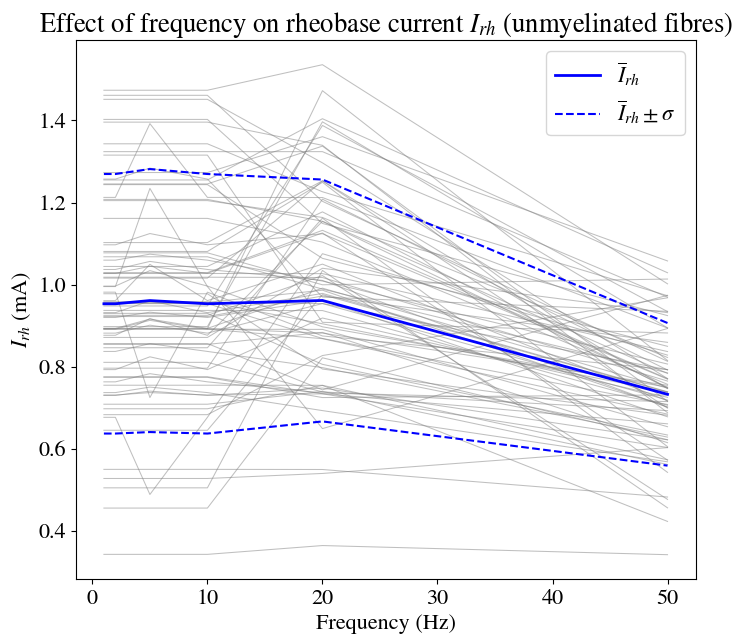

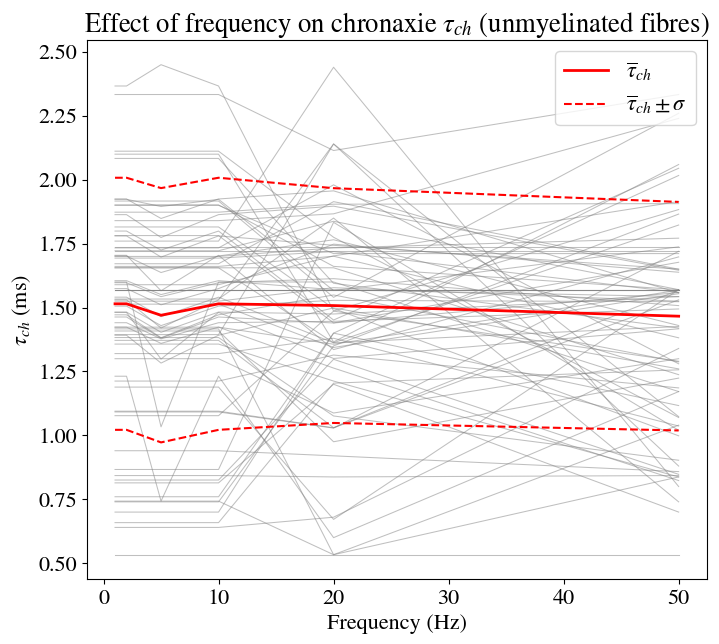

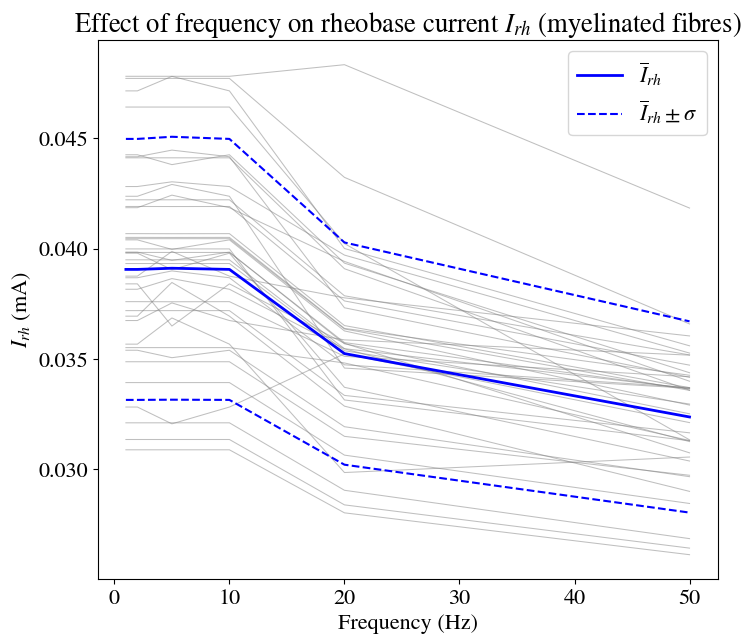

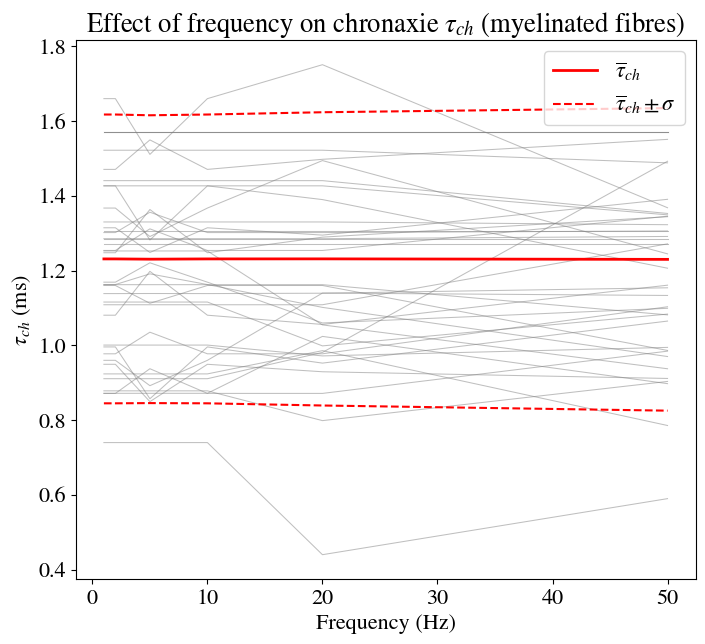

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 16

plt.rcParams['mathtext.fontset'] = 'stix'  # Use STIX fonts, which are similar to LaTeX fonts
plt.rcParams['font.family'] = 'STIXGeneral'  # Set general font family to STIXGeneral
plt.rcParams['mathtext.it'] = 'serif:italic'  # Make math text italic

# Function to calculate and plot only activation levels with all frequency values
def plot_mean_and_std_with_filtered_activations(params_df, fibre_type):
    # Get the unique frequencies present in the dataset
    all_frequencies = params_df['Frequency'].unique()
    all_frequencies = np.sort(all_frequencies)

    valid_activation_levels = []

    # Identify activation levels that have data for all frequencies
    for activation_level in params_df['Activation Level'].unique():
        subset = params_df[params_df['Activation Level'] == activation_level]
        if set(subset['Frequency'].unique()) == set(all_frequencies):
            valid_activation_levels.append(activation_level)

    # Filter the dataset to include only the valid activation levels
    filtered_params = params_df[params_df['Activation Level'].isin(valid_activation_levels)]

    # Calculate and plot the mean and standard deviation across valid activation levels
    mean_std_df = filtered_params.groupby('Frequency').agg({
        'I_rh': ['mean', 'std'],
        'T_ch': ['mean', 'std']
    }).reset_index()

    # Prepare the plot
    plt.figure(figsize=(8, 7))

    # Plot individual lines for each activation level
    for activation_level in valid_activation_levels:
        subset = filtered_params[filtered_params['Activation Level'] == activation_level]
        mean_params = subset.groupby('Frequency').agg({'I_rh': 'mean', 'T_ch': 'mean'}).reset_index()

        # Plotting I_rh (light lines)
        plt.plot(mean_params['Frequency'], mean_params['I_rh'], color='gray', linestyle='-', alpha=0.5, linewidth=0.75)


    # Plotting mean and standard deviation for I_rh
    plt.plot(mean_std_df['Frequency'], mean_std_df['I_rh']['mean'], color='blue', linestyle='-', label='$\\overline{I}_{rh}$', linewidth=2)
    plt.plot(mean_std_df['Frequency'], mean_std_df['I_rh']['mean'] + mean_std_df['I_rh']['std'], color='blue', linestyle='--', label='$\\overline{I}_{rh} \pm \\sigma$', linewidth=1.5)
    plt.plot(mean_std_df['Frequency'], mean_std_df['I_rh']['mean'] - mean_std_df['I_rh']['std'], color='blue', linestyle='--', label='_nolegend_', linewidth=1.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('$I_{rh}$ (mA)')
    # plt.grid(True)
    plt.title(f'Effect of frequency on rheobase current $I_{{rh}}$ ({"unmyelinated fibres" if fibre_type == 1 else "myelinated fibres"})')
    plt.legend(loc='upper right')
    plt.savefig(f'rheobase-frequency-{fibre_type}.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'rheobase-frequency-{fibre_type}.eps', dpi=300, bbox_inches='tight', format='eps')
    plt.show()


    plt.figure(figsize=(8, 7))

    # Plot individual lines for each activation level
    for activation_level in valid_activation_levels:
        subset = filtered_params[filtered_params['Activation Level'] == activation_level]
        mean_params = subset.groupby('Frequency').agg({'I_rh': 'mean', 'T_ch': 'mean'}).reset_index()

        # Plotting T_ch (light lines)
        plt.plot(mean_params['Frequency'], mean_params['T_ch'], color='gray', linestyle='-', alpha=0.5, linewidth=0.75)


    # Plotting mean and standard deviation for T_ch
    plt.plot(mean_std_df['Frequency'], mean_std_df['T_ch']['mean'], color='red', linestyle='-', label='$\\overline{\\tau}_{ch}$', linewidth=2)
    plt.plot(mean_std_df['Frequency'], mean_std_df['T_ch']['mean'] + mean_std_df['T_ch']['std'], color='red', linestyle='--', label='$\\overline{\\tau}_{ch} \pm \\sigma$', linewidth=1.5)
    plt.plot(mean_std_df['Frequency'], mean_std_df['T_ch']['mean'] - mean_std_df['T_ch']['std'], color='red', linestyle='--', label='_nolegend_', linewidth=1.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('$\\tau_{ch}$ (ms)')
    plt.title(f'Effect of frequency on chronaxie $\\tau_{{ch}}$ ({"unmyelinated fibres" if fibre_type == 1 else "myelinated fibres"})')
    # plt.grid(True)
    plt.legend(loc='upper right')
    plt.savefig(f'chronaxie-frequency-{fibre_type}.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'chronaxie-frequency-{fibre_type}.eps', dpi=300, bbox_inches='tight', format='eps')
    plt.show()

# Plot for fibre type 1
plot_mean_and_std_with_filtered_activations(params_fibre_1, fibre_type=1)

# Plot for fibre type 0
plot_mean_and_std_with_filtered_activations(params_fibre_0, fibre_type=0)


In [3]:
%pip install pysr

Note: you may need to restart the kernel to use updated packages.


In [4]:
params_fibre_1.head()

nerve_a     nerve_b  fibre_type  Activation Level  Frequency      I_rh  \
0  136.812897  119.578697           1            0.0196        1.0  1.041122   
1  136.812897  119.578697           1            0.0294        1.0  0.935096   
2  136.812897  119.578697           1            0.0588        1.0  0.769374   
3  136.812897  119.578697           1            0.0784        1.0  1.175271   
4  136.812897  119.578697           1            0.1863        1.0  1.186751   

       T_ch  
0  0.742857  
1  1.500000  
2  1.700000  
3  1.300000  
4  1.066667

In [5]:
import pandas as pd
import numpy as np
from pysr import PySRRegressor
import matplotlib.pyplot as plt

# Assuming `params_fibre_1` or `params_fibre_0` contains data for all fibers
# Example with params_fibre_1

# Step 1: Extract I_rh0 (when f = 1) for each nerve fiber
params_fibre_1['I_rh0'] = params_fibre_1.groupby(['nerve_a', 'nerve_b', 'Activation Level'])['I_rh'].transform(
    lambda x: x[params_fibre_1['Frequency'] == 1].mean() if sum(params_fibre_1['Frequency'] == 1) > 0 else np.nan)

# Drop rows where we don't have I_rh0 data
params_fibre_1.dropna(subset=['I_rh0'], inplace=True)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


c:\Users\btari\miniconda3\envs\ml\Lib\site-packages\pysr\sr.py:915: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
c:\Users\btari\miniconda3\envs\ml\Lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\btari\miniconda3\envs\ml\Lib\site-packages\pysr\sr.py:73: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.920e+04
Head worker occupation: 30.9%
Progress: 37 / 15000 total iterations (0.247%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           2.834e-01  7.971e+00  y = exp(-0.69985)
3           1.864e-02  2.721e+00  y = x₁ * 0.96059
4           1.864e-02  1.318e-04  y = x₁ * exp(-0.038598)
5           1.541e-02  1.903e-01  y = x₁ ^ (0.98506 ^ x₀)
6           1.312e-02  1.608e-01  y = x₁ / exp(0.0068551 * x₀)
7           1.202e-02  8.774e-02  y = x₁ * ((0.95363 ^ x₀) ^ 0.10469)
8           1.201e-02  6.717e-04  y = exp((0.0068551 * x₀) * -0.70067) * x₁
9           9.804e-03  2.031e-01  y = x₁ - ((0.0086793 * (x₁ * x₀)) ^ 2.0585)
11          9.074e-03  3.866e-02  y = x₁ - (x₁ * ((0.0086793 * (x₁ * x₀)) ^ 2.0585))
14          8.878e-03  7.294e-03  y = x₁ - ((0.0086793 * ((x₀ * x₁) + -0.03312)) ^ (exp(0.53674)...
                               

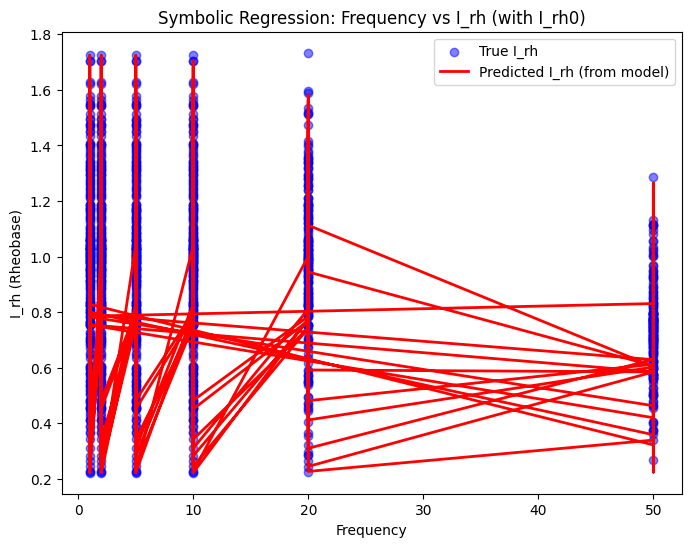

In [6]:
# Prepare the data for symbolic regression
# Inputs: Frequency and I_rh0
X = params_fibre_1[['Frequency', 'I_rh0']].values  # Frequency and I_rh0 as inputs
y = params_fibre_1['I_rh'].values                 # Rheobase current (I_rh) as the target

# Step 3: Initialize and fit the symbolic regression model
model = PySRRegressor(
    niterations=1000,                             # Number of iterations
    binary_operators=["+", "*", "-", "/", "^"],    # Allowed binary operations
    unary_operators=["exp", "log"],  # Allowed unary operations
    maxsize=20,                                    # Limit the complexity of expressions
    loss="loss(x, y) = (x - y)^2",                # Mean squared error
    verbosity=1
)

# Fit the model: X contains the Frequency and I_rh0, y is the target I_rh
model.fit(X, y)

# Step 4: Print the best-found equation
print(f"Best found equation for the relationship between Frequency, I_rh0, and I_rh: {model}")

# Step 5: Optionally plot the true I_rh vs predicted I_rh
predictions = model.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], y, label='True I_rh', color='blue', alpha=0.5)
plt.plot(X[:, 0], predictions, label='Predicted I_rh (from model)', color='red', linewidth=2)
plt.xlabel('Frequency')
plt.ylabel('I_rh (Rheobase)')
plt.title('Symbolic Regression: Frequency vs I_rh (with I_rh0)')
plt.legend()
plt.show()

In [17]:
data_fibre_0.describe()

nerve_a       nerve_b   pulse_width     frequency     amplitude  \
count  13095.000000  13095.000000  13095.000000  13095.000000  13095.000000   
mean     244.069992    132.648865      1.282917     14.643833      0.036592   
std       52.466583     13.614189      1.364879     16.994728      0.025854   
min      136.812897    114.755402      0.200000      1.000000      0.011571   
25%      194.339005    119.578697      0.400000      2.000000      0.017311   
50%      249.881699    134.537003      0.800000     10.000000      0.025710   
75%      272.974213    142.425003      1.500000     20.000000      0.046859   
max      308.932190    159.531998      5.000000     50.000000      0.131816   

       activation_level  fibre_type        charge  
count      13095.000000     13095.0  13095.000000  
mean           0.528621         0.0      0.025898  
std            0.310835         0.0      0.012935  
min            0.025600         0.0      0.010991  
25%            0.256400         0.0      0.018173  
50%            0.512800         0.0      0.020937  
75%            0.820500         0.0      0.027688  
max            1.000000         0.0      0.066315

In [54]:
data_fibre_1 = data_fibre_1[data_fibre_1['activation_level'] > 0]
data_fibre_1.describe()

nerve_a       nerve_b   pulse_width     frequency     amplitude  \
count  18833.000000  18833.000000  18833.000000  18833.000000  18833.000000   
mean     247.108139    132.825577      1.504211     14.640684      0.920496   
std       51.041519     13.600079      1.551228     17.005207      1.037253   
min      136.812897    114.755402      0.200000      1.000000      0.116348   
25%      245.418701    120.351700      0.400000      2.000000      0.219795   
50%      258.748108    134.537003      0.800000      5.000000      0.452793   
75%      292.657593    135.586807      2.000000     20.000000      1.172500   
max      308.932190    159.531998      5.000000     50.000000      4.415872   

       activation_level  fibre_type        charge  
count      18833.000000     18833.0  18833.000000  
mean           0.508850         1.0      0.492029  
std            0.344538         0.0      0.124309  
min            0.009700         1.0      0.313375  
25%            0.156900         1.0      0.394951  
50%            0.509800         1.0      0.440000  
75%            0.862700         1.0      0.587208  
max            1.000000         1.0      0.883174